<a href="https://colab.research.google.com/github/crrivero/FormalMethodsTasting/blob/main/For%20life%20scientists/Biology_PPI_Clique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install networkx matplotlib z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 45.8 MB/s eta 0:00:00


✅ Clique of size 3 found: [TP53, CDKN1A, RB1]


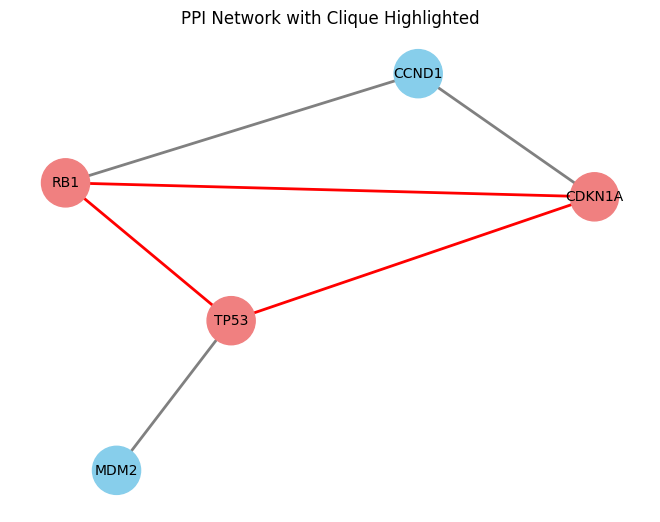

In [18]:
import networkx as nx
from z3 import *
import matplotlib.pyplot as plt

def visualize_ppi_network(edges, clique):
    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=42)

    # Set colors
    node_colors = ["lightcoral" if n in clique else "skyblue" for n in G.nodes()]
    edge_colors = ["red" if u in clique and v in clique else "gray" for u, v in G.edges()]

    # Layout and draw
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors,
        node_size=1200, font_size=10, width=2)
    plt.title("PPI Network with Clique Highlighted")
    plt.show()


# Protein	Name
# TP53	Tumor protein p53
# MDM2	E3 ubiquitin-protein ligase Mdm2
# CDKN1A	p21, cyclin-dependent kinase inhibitor
# CCND1	Cyclin D1
# RB1	Retinoblastoma-associated protein

k = 3 # Size of the clique to find.

# Step 1: Create Boolean variables for each protein
TP53, MDM2, CDKN1A, CCND1, RB1 = Bools("TP53 MDM2 CDKN1A CCND1 RB1")

proteins = [TP53, MDM2, CDKN1A, CCND1, RB1]

# Step 2: Define the protein-protein interaction matrix manually
# We'll only list the positive interactions
# i.e., TP53 interacts with MDM2, CDKN1A, RB1
interactions = {
    (TP53, MDM2),
    (TP53, CDKN1A),
    (TP53, RB1),
    (CDKN1A, RB1),
    (CDKN1A, CCND1),
    (RB1, CCND1),
}

# Step 3: Initialize Z3 solver
solver = Solver()

# Step 4: Add the clique size constraint (exactly k proteins selected)
solver.add(
    Sum([If(TP53, 1, 0), If(MDM2, 1, 0), If(CDKN1A, 1, 0),
         If(CCND1, 1, 0), If(RB1, 1, 0)]) == k)

# Step 5: Add constraints: if two proteins are selected, they must interact
# We explicitly write only the required constraints (no loop)
# For every unordered protein pair that does NOT interact, add:
#    Not(p1 ∧ p2)  ⇨  ¬(p1 ∧ p2) ⇨  (¬p1 ∨ ¬p2)

# Manually add constraints for non-edges
solver.add(Or(Not(MDM2), Not(CDKN1A)))
solver.add(Or(Not(MDM2), Not(CCND1)))
solver.add(Or(Not(MDM2), Not(RB1)))
solver.add(Or(Not(TP53), Not(CCND1)))


if solver.check() == sat:
    model = solver.model()
    clique = [v for v in proteins if is_true(model[v])]
    print(f"✅ Clique of size {k} found: {clique}")

    visualize_ppi_network(interactions, clique)
else:
    print(f"❌ No clique of size {k} found.")

# Expected result: ['TP53', 'CDKN1A', 'RB1']. These three proteins indeed form
# a functional module in cell cycle regulation.

✅ Clique of size 5 found: [TP53, MDM2, CDKN1A, CCND1, RB1]


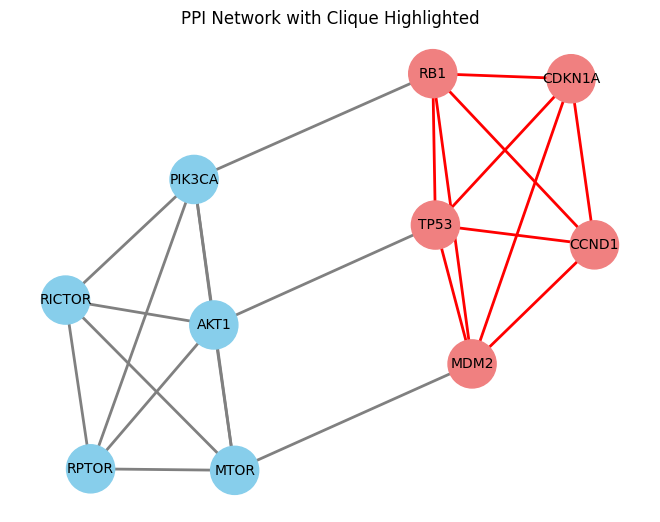

In [19]:
# Protein Names
# Clique 1: Cell cycle regulation
#   TP53     - Tumor suppressor protein p53
#   MDM2     - E3 ubiquitin-protein ligase
#   CDKN1A   - Cyclin-dependent kinase inhibitor p21
#   CCND1    - Cyclin D1
#   RB1      - Retinoblastoma-associated protein
#
# Clique 2: PI3K-Akt-mTOR signaling pathway
#   AKT1     - RAC-alpha serine/threonine-protein kinase
#   PIK3CA   - Phosphatidylinositol 4,5-bisphosphate 3-kinase
#   MTOR     - Mechanistic target of rapamycin
#   RPTOR    - Regulatory-associated protein of mTOR
#   RICTOR   - Rapamycin-insensitive companion of mTOR

k = 5

# Define Boolean variables for each protein
TP53, MDM2, CDKN1A, CCND1, RB1, AKT1, PIK3CA, MTOR, RPTOR, RICTOR = Bools(
    "TP53 MDM2 CDKN1A CCND1 RB1 AKT1 PIK3CA MTOR RPTOR RICTOR"
)

proteins = [TP53, MDM2, CDKN1A, CCND1, RB1, AKT1, PIK3CA, MTOR, RPTOR, RICTOR]

interactions = {
    # Clique 1 (TP53 complex)
    (TP53, MDM2),
    (TP53, CDKN1A),
    (TP53, CCND1),
    (TP53, RB1),
    (MDM2, CDKN1A),
    (MDM2, CCND1),
    (MDM2, RB1),
    (CDKN1A, CCND1),
    (CDKN1A, RB1),
    (CCND1, RB1),

    # Clique 2 (PI3K-Akt-mTOR complex)
    (AKT1, PIK3CA),
    (AKT1, MTOR),
    (AKT1, RPTOR),
    (AKT1, RICTOR),
    (PIK3CA, MTOR),
    (PIK3CA, RPTOR),
    (PIK3CA, RICTOR),
    (MTOR, RPTOR),
    (MTOR, RICTOR),
    (RPTOR, RICTOR),

    # Other edges
    (TP53, AKT1),
    (MDM2, MTOR),
    (RB1, PIK3CA),
}

solver = Solver()

solver.add(
    Sum([If(p, 1, 0) for p in proteins]) == k)

for i in range(0, len(proteins)):
  pi = proteins[i]

  for j in range(i+1, len(proteins)):
    pj = proteins[j]

    if (pi, pj) not in interactions and (pj, pi) not in interactions:
      solver.add(Or(Not(pi), Not(pj)))

if solver.check() == sat:
  model = solver.model()
  clique = [v for v in proteins if is_true(model[v])]
  print(f"✅ Clique of size {k} found: {clique}")

  visualize_ppi_network(interactions, clique)
else:
    print(f"❌ No clique of size {k} found.")

# To find the second clique, we need something extra besides Z3.